In [1]:
from fl_clientlib import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
from keras.optimizers import Adam

In [2]:
img_path = input("Enter image or dataframe.csv path\n")
data_frame = load(img_path, verbose=10000)

['../train/dataframe.csv']


In [3]:
data_frame.head()

Unnamed: 0                                              Image  Covid  \
0           0  ../train/1/5CBC2E94-D358-401E-8928-965CCD965C5...    1.0   
1           1  ../train/1/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E8...    1.0   
2           2    ../train/1/1-s2.0-S0140673620303706-fx1_lrg.jpg    1.0   
3           3  ../train/1/6CB4EFC6-68FA-4CD5-940C-BEFA8DAFE9A...    1.0   
4           4  ../train/1/D5ACAA93-C779-4E22-ADFA-6A220489F84...    1.0   

   Normal  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [4]:
data_frame.tail()

Unnamed: 0                                 Image  Covid  Normal
320         320  ../train/0/NORMAL2-IM-0414-0001.jpeg    0.0     1.0
321         321  ../train/0/NORMAL2-IM-0744-0001.jpeg    0.0     1.0
322         322  ../train/0/NORMAL2-IM-0516-0001.jpeg    0.0     1.0
323         323  ../train/0/NORMAL2-IM-0595-0001.jpeg    0.0     1.0
324         324  ../train/0/NORMAL2-IM-0507-0001.jpeg    0.0     1.0

In [5]:
train_df, valid_df, test_df = \
              np.split(data_frame.sample(frac=1, random_state=42), 
                       [int(.8*len(data_frame)), int(.9*len(data_frame))])
labels = ['Covid', 'Normal']

In [6]:
IMAGE_DIR = ""#To be replaced
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

x, y = train_generator.__getitem__(0)
v, w = valid_generator.__getitem__(0)
print(v[0].shape)
print(x[0].shape)

getting train generator...
Found 260 validated image filenames.
getting train and valid generators...
Found 260 validated image filenames.
Found 32 validated image filenames.
Found 33 validated image filenames.
(32, 32, 1)
(32, 32, 1)


    Class     Label     Value
0   Covid  Positive  0.145621
1  Normal  Positive  0.145621
2   Covid  Negative  0.145621
3  Normal  Negative  0.145621


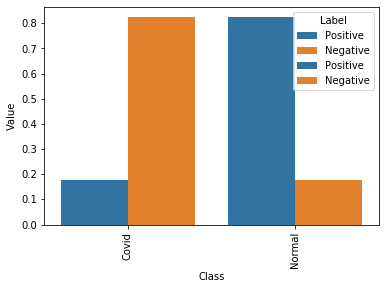

In [7]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);
print(data.head())

In [8]:
steps_per_epoch = train_generator.labels.shape[0]//train_generator.batch_size
validation_steps = valid_generator.labels.shape[0]//valid_generator.batch_size

In [ ]:
sio = socketio.Client()

class Flnamespace(socketio.ClientNamespace):

    def get_weighted_loss(self, pos_weights, neg_weights, epsilon=1e-7):
        def weighted_loss(y_true, y_pred):
            loss = 0.0
            for i in range(len(pos_weights)):
                # for each class, add average weighted loss for that class 
                loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                    neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
            return loss
        return weighted_loss

    def train_model(self, server_packet):
        model = server_packet["model"]
        n_round = server_packet["n_round"]
        if(n_round==1):
            self.model = model_from_json(model)
            self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        else:
            
            model = pickle_string_to_obj(model)
            print(len(model))
            print(model[0].shape)
            self.model.set_weights(model)
            n_round = server_packet["n_round"]
            
            predicted_vals = self.model.predict(test_generator, steps = len(test_generator))
    
            cm = confusion_matrix(test_generator.labels[:,0], predicted_vals[:,0].round())
            plt.imshow(cm, cmap='binary')
            plt.show()
        
        print("Preparing to train model")
        
        print(f"===Round {n_round}===")
        history = self.model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch = steps_per_epoch,#steps_per_epoch, 
                              validation_steps = validation_steps,#validation_steps, 
                              epochs = 2)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(["loss", "val_loss"])
        plt.xlabel("epoch")
        plt.title("Loss Curve")
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.legend(["accuracy", "binary_accuracy"])
        plt.xlabel("epoch")
        plt.title("Accuracy Curve")
        plt.show()


        weights = self.model.get_weights()
        print(len(weights))
        print(weights[0].shape)
        score = self.model.evaluate(test_generator, verbose=0)
        print("Model trained and new weights are being sent to server")
        self.model.save('model.h5')
    
        sio.emit("complete_round", {"weights": obj_to_pickle_string(weights), "n_train": train_generator.labels.shape[0], "n_test": test_generator.labels.shape[0], "scores": score, "n_round": n_round}, callback=self.train_model)

    def on_connect(self):
        print("Server connected")
        sio.emit("model_request", {"pos": msgpack.packb(pos_weights, default=m.encode), "neg": msgpack.packb(neg_weights, default=m.encode)})

    def on_sending_model(self, server_packet):
        print("Client receiving model")
        self.train_model(server_packet)

    def on_disconnect(self):
        print("Server disconnected")

class Flclient():

    def __init__(self):
        
        sio.register_namespace(Flnamespace())

    def start(self, url):
        sio.connect(url)
        sio.wait()

    def stop(self):
        sio.disconnect()


In [10]:
fl_client = Flclient()
url = input("Enter the server's url\n")

In [ ]:
fl_client.start(url)

In [13]:
fl_client.stop()